In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class BernCluster:
    def __init__(self, theta):
        self.theta = theta
        self.expected = np.array([theta, 1-theta])
        
    def feedback(self, arm):
        if arm >= 2:
            print("BernCluster.feedback: index out of num_arms within the cluster")
            return None
        return 1 if random.random() < self.expected[arm] else 0
    
    def payoff(self):
        return self.expected
        
class BernClusterLearner:
    def __init__(self):
        self.obs_avg = np.array([0.0 for i in range(2)])
        self.obs_cnt = np.array([0 for i in range(2)])
        
    def receive_feedback(self, arm, reward):
        if arm >= 2:
            print("BernClusterLearner.receive_feedback: index out of num_arms within the cluster")
            return
        self.obs_avg[arm] = (self.obs_avg[arm] * self.obs_cnt[arm] + reward)/(self.obs_cnt[arm] + 1)
        self.obs_cnt[arm] += 1
        
    def clear_obs(self):
        self.obs_avg = np.array([0.0 for i in range(2)])
        self.obs_cnt = np.array([0 for i in range(2)])
        
    def mle(self):
        return (self.obs_avg[0]*self.obs_cnt[0] + (1-self.obs_avg[1])*self.obs_cnt[1])/np.sum(self.obs_cnt)
    
    def explore_bonus(self, t):
        return np.log(t)
    
    def ucb(self, t):
        return self.obs_avg + np.sqrt(2*self.explore_bonus(t)/self.obs_cnt)
    
    def ucb_c(self, t):
        theta = self.mle()
        bonus = 2*self.explore_bonus(t)/np.sum(self.obs_cnt)
        def fun(x):
            return my_kl_minus_bonus(theta, x, bonus)
        def my_bisect(a,b,tol=0.0001, N=1000):
            if a >= b:
                return (a+b)/2 
            if fun(a)*fun(b) >= 0:
                print(f"Bisection method fails. a: {a}, b:{b}")
                return None
            a_n = a
            b_n = b
            for n in range(1,N+1):
                m_n = (a_n + b_n)/2
                f_m_n = fun(m_n)
                if f_m_n == 0 or abs(f_m_n) < tol:
                    #print(f"Found exact solution at {n}")
                    return m_n
                elif fun(a_n)*f_m_n < 0:
                    a_n = a_n
                    b_n = m_n
                elif fun(b_n)*f_m_n < 0:
                    a_n = m_n
                    b_n = b_n
                else:
                    print(f"Bisection method fails. a: {a}, b:{b}")
                    return None
            return (a_n + b_n)/2
        
        return np.array([my_bisect(theta, 1.0), 1 - my_bisect(0.0, theta)])
    
    def mle_g(self):
        arm = np.argmax(self.obs_cnt)
        return self.obs_avg[arm] if arm==0 else 1 - self.obs_avg[arm]
    
    def ucb_g(self, t):
        theta = self.mle_g()
        ucb = np.max([theta, 1-theta]) + np.sqrt(2*self.explore_bonus(t)/np.sum(self.obs_cnt))
        mu = np.array([theta, 1-theta])
        return ucb, mu

In [3]:
def my_kl_minus_bonus(theta, lbd, bonus):
    if theta == 0:
        kl = - np.log(1-lbd) if lbd <1 else math.inf
    elif theta == 1:
        kl = - np.log(lbd) if lbd >0 else math.inf
    else:
        if lbd == 0 or lbd == 1:
            kl = math.inf
        else:
            kl = theta * np.log(theta/lbd) + (1-theta) * np.log((1-theta)/(1-lbd))
    return kl - bonus



In [4]:
class BernClusterEnvironment:
    def __init__(self, theta_array):
        self.num_cluster = len(theta_array)
        self.theta_array = theta_array
        self.clusters = []
        for i in range(self.num_cluster):
            self.clusters.append(BernCluster(theta_array[i]))
    
    def regret_per_action(self):
        payoffs = []
        for cluster in self.clusters:
            payoffs.append(cluster.payoff())
        largest = np.max([np.max(p) for p in payoffs])
        delta = [largest - p for p in payoffs]
        return delta
        
    def feedback(self, cluster, arm):
        return self.clusters[cluster].feedback(arm)

In [5]:
class BernClusterTestBed:
    def __init__(self, theta_array):
        self.num_cluster = len(theta_array)
        self.num_arms = [2 for i in range(self.num_cluster)]
        self.theta_array = theta_array
        self.environment = BernClusterEnvironment(theta_array)
        self.learners = [BernClusterLearner() for i in range(self.num_cluster)]
        self.delta = self.environment.regret_per_action()
        
    def reset_learners(self):
        for l in self.learners:
            l.clear_obs()
            
    def display_learners(self):
        for cl in self.learners:
            print(cl.obs_avg)
            print(cl.obs_cnt)
        
    def ucb(self, T):
        regret = []
        #initialize
        for c in range(self.num_cluster):
            for arm in range(self.num_arms[c]):
                reward = self.environment.feedback(c,arm)
                self.learners[c].receive_feedback(arm, reward)
                regret.append(self.delta[c][arm])
        #print("finished initialize")
        #self.display_learners()
        for t in range(sum(self.num_arms),T):
            ucbs = [cl.ucb(t) for cl in self.learners]
            largests = [np.max(ucb) for ucb in ucbs]
            #print(f"largests:{largests}")
            dec_c = np.argmax(largests)
            dec_arm = np.argmax(ucbs[dec_c])
            #print(f"decision = cluster:{dec_c}, arm:{dec_arm}")
            reward = self.environment.feedback(dec_c, dec_arm)
            self.learners[dec_c].receive_feedback(dec_arm, reward)
            regret.append(self.delta[dec_c][dec_arm])
        return regret
    
    def ucb_c(self, T):
        regret = []
        #initialize
        for c in range(self.num_cluster):
            arm = self.num_arms[c]-1
            reward = self.environment.feedback(c, arm)
            self.learners[c].receive_feedback(arm, reward)
            regret.append(self.delta[c][arm])
        for t in range(self.num_cluster, T):
            ucbs = [cl.ucb_c(t) for cl in self.learners]
            largests = [np.max(ucb) for ucb in ucbs]
            dec_c = np.argmax(largests)
            dec_arm = np.argmax(ucbs[dec_c])
            reward = self.environment.feedback(dec_c, dec_arm)
            self.learners[dec_c].receive_feedback(dec_arm, reward)
            regret.append(self.delta[dec_c][dec_arm])
        return regret
    
    def ucb_g(self, T):
        regret = []
        #initialize
        for c in range(self.num_cluster):
            arm = self.num_arms[c]-1
            reward = self.environment.feedback(c, arm)
            self.learners[c].receive_feedback(arm, reward)
            regret.append(self.delta[c][arm])
        for t in range(self.num_cluster, T):
            ucbs = []
            mus = []
            for cl in self.learners:
                ucb, mu = cl.ucb_g(t)
                ucbs.append(ucb)
                mus.append(mu)
            dec_c = np.argmax(ucbs)
            dec_arm = np.argmax(mus[dec_c])
            reward = self.environment.feedback(dec_c, dec_arm)
            self.learners[dec_c].receive_feedback(dec_arm, reward)
            regret.append(self.delta[dec_c][dec_arm])
        return regret
    
    def ucb_perf(self, T, repeat):
        avg_regret = np.array([0.0 for i in range(T)])
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb(T))
            avg_regret += regret/repeat
        return np.cumsum(avg_regret)
    
    def ucb_c_perf(self, T, repeat):
        avg_regret = np.array([0.0 for i in range(T)])
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb_c(T))
            avg_regret += regret/repeat
        return np.cumsum(avg_regret)
    
    def ucb_g_perf(self, T, repeat):
        avg_regret = np.array([0.0 for i in range(T)])
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb_g(T))
            avg_regret += regret/repeat
        return np.cumsum(avg_regret)
    
    def ucb_perf_ci(self, T, repeat):
        all_regret = []
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb(T))
            all_regret.append(regret.cumsum())
        all_regret_array = np.array(all_regret)
        avg_regret = all_regret_array.mean(axis=0)
        dev_regret = all_regret_array.std(axis=0)
        return avg_regret, dev_regret
    
    def ucb_c_perf_ci(self, T, repeat):
        all_regret = []
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb_c(T))
            all_regret.append(regret.cumsum())
        all_regret_array = np.array(all_regret)
        avg_regret = all_regret_array.mean(axis=0)
        dev_regret = all_regret_array.std(axis=0)
        return avg_regret, dev_regret
    
    def ucb_g_perf_ci(self, T, repeat):
        all_regret = []
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb_g(T))
            all_regret.append(regret.cumsum())
        all_regret_array = np.array(all_regret)
        avg_regret = all_regret_array.mean(axis=0)
        dev_regret = all_regret_array.std(axis=0)
        return avg_regret, dev_regret
    
    def ucb_perf_percentile(self, T, repeat):
        all_regret = []
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb(T))
            all_regret.append(regret.cumsum())
        all_regret_array = np.array(all_regret)
        avg_regret = all_regret_array.mean(axis=0)
        ub_regret = np.percentile(all_regret_array, 90, axis=0)
        lb_regret = np.percentile(all_regret_array, 10, axis=0)
        return avg_regret, ub_regret, lb_regret
    
    def ucb_c_perf_percentile(self, T, repeat):
        all_regret = []
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb_c(T))
            all_regret.append(regret.cumsum())
        all_regret_array = np.array(all_regret)
        avg_regret = all_regret_array.mean(axis=0)
        ub_regret = np.percentile(all_regret_array, 90, axis=0)
        lb_regret = np.percentile(all_regret_array, 10, axis=0)
        return avg_regret, ub_regret, lb_regret
    
    def ucb_g_perf_percentile(self, T, repeat):
        all_regret = []
        for run in range(repeat):
            #reset learners
            self.reset_learners()
            regret = np.array(self.ucb_g(T))
            all_regret.append(regret.cumsum())
        all_regret_array = np.array(all_regret)
        avg_regret = all_regret_array.mean(axis=0)
        ub_regret = np.percentile(all_regret_array, 90, axis=0)
        lb_regret = np.percentile(all_regret_array, 10, axis=0)
        return avg_regret, ub_regret, lb_regret
            

# percentile plot

KeyboardInterrupt: 

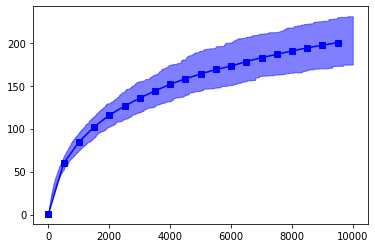

In [41]:
theta_array = [0.1, 0.5, 0.2]
T = 10000
repeat = 100
plt_sample = range(1,T+1,int(T/20))
mytestbed = BernClusterTestBed(theta_array)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'bs-', label='UCB')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='blue', alpha=0.5)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_g_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'y--', label='UCB-g')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='yellow', alpha=0.5)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_c_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'r', label='UCB-C')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='red', alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average regret', fontsize=15)
plt.savefig('cluster1.pdf')
plt.show()

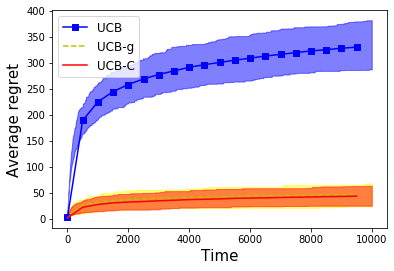

In [33]:
num_arms = [10,5,10]
theta_array = [0.1, 0.5, 0.2]
sigma_array = [1,1,1]
T = 10000
repeat = 100
plt_sample = range(1,T+1,int(T/20))
mytestbed = NormalClusterTestBed(num_arms, theta_array, sigma_array)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'bs-', label='UCB')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='blue', alpha=0.5)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_g_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'y--', label='UCB-g')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='yellow', alpha=0.5)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_c_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'r', label='UCB-C')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='red', alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average regret', fontsize=15)
plt.savefig('cluster2.pdf')
plt.show()

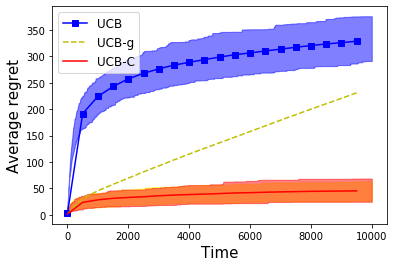

In [34]:
num_arms = [10,5,10]
theta_array = [0.1, 0.5, 0.2]
sigma_array = [1,1,1]
T = 10000
repeat = 100
plt_sample = range(1,T+1,int(T/20))
mytestbed = NormalClusterTestBed(num_arms, theta_array, sigma_array)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'bs-', label='UCB')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='blue', alpha=0.5)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_g_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'y--', label='UCB-g')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='yellow', alpha=0.5)

avg_regret, ub_regret, lb_regret = mytestbed.ucb_c_perf_percentile(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'r', label='UCB-C')
plt.fill_between(np.arange(T), ub_regret, lb_regret, color='red', alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average regret', fontsize=15)
#plt.savefig('cluster2.pdf')
plt.show()

# CI plot

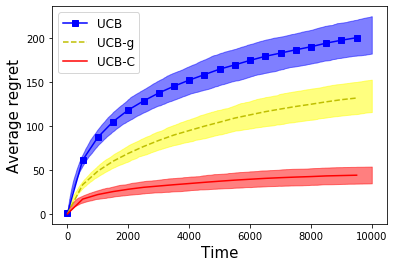

In [10]:
theta_array = [0.1, 0.5, 0.2]
T = 10000
repeat = 100
plt_sample = range(1,T+1,int(T/20))
mytestbed = BernClusterTestBed(theta_array)

avg_regret, dev_regret = mytestbed.ucb_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'bs-', label='UCB')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='blue', alpha=0.5)

avg_regret, dev_regret = mytestbed.ucb_g_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'y--', label='UCB-g')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='yellow', alpha=0.5)

avg_regret, dev_regret = mytestbed.ucb_c_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'r', label='UCB-C')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='red', alpha=0.5)

plt.legend(fontsize=12, loc="upper left")
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average regret', fontsize=15)
plt.savefig('Berncluster1_CI.pdf')
plt.show()

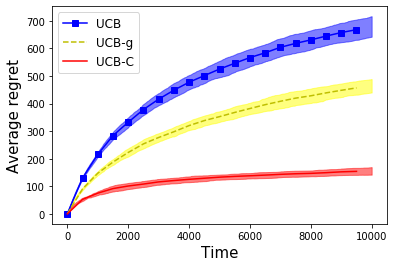

In [11]:
theta_array = [0.1, 0.5, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.5]
T = 10000
repeat = 20
plt_sample = range(1,T+1,int(T/20))
mytestbed = BernClusterTestBed(theta_array)

avg_regret, dev_regret = mytestbed.ucb_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'bs-', label='UCB')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='blue', alpha=0.5)

avg_regret, dev_regret = mytestbed.ucb_g_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'y--', label='UCB-g')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='yellow', alpha=0.5)

avg_regret, dev_regret = mytestbed.ucb_c_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'r', label='UCB-C')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='red', alpha=0.5)

plt.legend(fontsize=12, loc="upper left")
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average regret', fontsize=15)
plt.savefig('Berncluster2_CI.pdf')
plt.show()

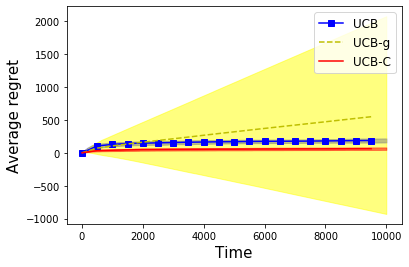

In [35]:
num_arms = [3,2,3]
theta_array = [0.1, 0.5, 0.2]
sigma_array = [1,1,1]
T = 10000
repeat = 20
plt_sample = range(1,T+1,int(T/20))
mytestbed = NormalClusterTestBed(num_arms, theta_array, sigma_array)

avg_regret, dev_regret = mytestbed.ucb_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'bs-', label='UCB')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='blue', alpha=0.5)

avg_regret, dev_regret = mytestbed.ucb_g_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'y--', label='UCB-g')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='yellow', alpha=0.5)

avg_regret, dev_regret = mytestbed.ucb_c_perf_ci(T,repeat)
plt.plot(plt_sample,[avg_regret[i-1] for i in plt_sample], 'r', label='UCB-C')
plt.fill_between(np.arange(T),avg_regret + dev_regret, avg_regret - dev_regret, color='red', alpha=0.5)

plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average regret', fontsize=15)
#plt.savefig('cluster1.pdf')
plt.show()

# average plot

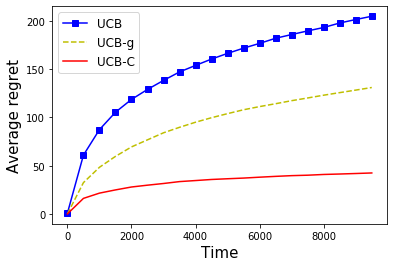

In [8]:
theta_array = [0.1, 0.5, 0.2]
T = 10000
repeat = 100
plt_sample = range(1,T+1,int(T/20))
mytestbed = BernClusterTestBed(theta_array)
output = mytestbed.ucb_perf(T,repeat)
plt.plot(plt_sample,[output[i-1] for i in plt_sample], 'bs-', label='UCB')
output = mytestbed.ucb_g_perf(T,repeat)
plt.plot(plt_sample,[output[i-1] for i in plt_sample], 'y--', label='UCB-g')
output = mytestbed.ucb_c_perf(T,repeat)
plt.plot(plt_sample,[output[i-1] for i in plt_sample], 'r', label='UCB-C')
plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average regret', fontsize=15)
plt.savefig('Berncluster1.pdf')
plt.show()

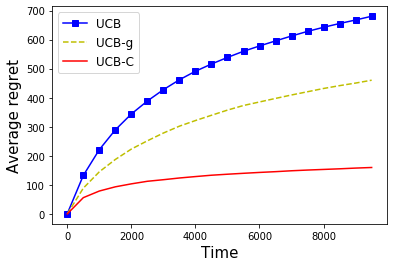

In [9]:
theta_array = [0.1, 0.5, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.5]
T = 10000
repeat = 100
plt_sample = range(1,T+1,int(T/20))
mytestbed = BernClusterTestBed(theta_array)
output = mytestbed.ucb_perf(T,repeat)
plt.plot(plt_sample,[output[i-1] for i in plt_sample], 'bs-', label='UCB')
output = mytestbed.ucb_g_perf(T,repeat)
plt.plot(plt_sample,[output[i-1] for i in plt_sample], 'y--', label='UCB-g')
output = mytestbed.ucb_c_perf(T,repeat)
plt.plot(plt_sample,[output[i-1] for i in plt_sample], 'r', label='UCB-C')
plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average regret', fontsize=15)
plt.savefig('Berncluster2.pdf')
plt.show()

In [4]:
num = 3
obs_avg = np.array([0 for i in range(num)])
obs_cnt = np.array([0 for i in range(num)])
obs_avg[1] = (obs_avg[1] * obs_cnt[1] + 1)/(obs_cnt[1] + 1)
obs_cnt[1] += 1

In [5]:
obs_avg

array([0, 1, 0])

In [6]:
obs_cnt

array([0, 1, 0])

In [8]:
np.sum(obs_avg * obs_cnt)

1

In [9]:
np.array(range(num))+1

array([1, 2, 3])

In [12]:
np.log(3)

1.0986122886681098

In [13]:
np.sqrt(10)

3.1622776601683795

In [18]:
payoff = [np.array([1,2,3,4]), np.array([-1,-2,-3])]
payoff

[array([1, 2, 3, 4]), array([-1, -2, -3])]

In [22]:
largest = np.max([np.max(p) for p in payoff])
largest

4

In [23]:
delta = [largest - p for p in payoff]
delta

[array([3, 2, 1, 0]), array([5, 6, 7])]

In [26]:
delta[0][2]

1

In [28]:
a = np.array(range(10))
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [29]:
np.cumsum(a)

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45], dtype=int32)